**Demonstrates a practical application of time series forecasting techniques, including statistical models and machine learning approaches including Generative AI for time series (TimeGPT). The chat function and prototype model further illustrate how these forecasts can be used for real-world decision-making.**

In this project we demonstrate a comprehensive approach to time series forecasting for natural gas prices using time Series Forecasting Models like

**ARIMA:** Autoregressive Integrated Moving Average model.  <br>
**SARIMA:** Seasonal ARIMA model, accounting for seasonality.  <br>
**Exponential Smoothing:** A statistical method for forecasting time series data.  <br>
**TimeGPT:** A language model-based forecasting approach from Nixtla.  <br>

We evaluate the performance of each model using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).Identify the best-performing model based on these metrics.

We attempt to improve TimeGPT's performance by fine-tuning it with the Mean Absolute Error loss function.

Combining Forecasts and Visualization:

We combine the historical data with forecasts from all models.
Visualizes the historical data and forecasts on a single plot for comparison.
Chat Function:

We create a chat function to provide price estimates for specific dates based on the historical data and forecasts.

We defines a prototype model to simulate a natural gas storage scenario.
Calculates potential profit or loss based on injection and withdrawal dates, prices, and other factors.

##Imports and Setup:

In [295]:
%pip install nixtla>=0.5.1

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [297]:
from google.colab import userdata
timegpt_api_key = userdata.get('TIMEGPT_API_KEY')

In [298]:

from nixtla import NixtlaClient
import os

In [299]:
# Setup NixtlaClient
nixtla_client = NixtlaClient(api_key=timegpt_api_key)

## Loading and Plotting Historical Data:

In [300]:
NaturalGas = pd.read_csv('Nat_Gas.csv')
NaturalGas

,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84
8,6/30/21,10.00
9,7/31/21,10.10


In [301]:
import pandas as pd
import plotly.express as px

# Assuming the CSV has already been loaded
NaturalGas['Dates'] = pd.to_datetime(NaturalGas['Dates'])

# Create the Plotly line chart
fig = px.line(NaturalGas, x='Dates', y='Prices', title='Natural Gas Prices Over Time',
              labels={'Prices': 'Price', 'Dates': 'Date'}, markers=True)

# Show the interactive plot
fig.show()


<ipython-input-301-d916342b3bd1>:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



##ARIMA Forecasting:

In [302]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (order can be tuned for better performance)
model_arima = ARIMA(NaturalGas['Prices'], order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# Forecast for the next 12 months
forecast_arima = model_arima_fit.forecast(steps=12)

# Generate future dates for the next 12 months
last_date = NaturalGas['Dates'].iloc[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=12, freq='M')

# Create DataFrame for ARIMA forecast
forecast_arima_df = pd.DataFrame({
    'Dates': future_dates,
    'Prices': forecast_arima
})


<ipython-input-302-543dd225caca>:12: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [303]:
# Combine with historical data
forecast_arima_df = pd.concat([NaturalGas, forecast_arima_df], ignore_index=True)



##SARIMA Forecasting:

In [304]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model (order and seasonal_order can be tuned for better performance)
model_sarima = SARIMAX(NaturalGas['Prices'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()

# Forecast for the next 12 months
forecast_sarima = model_sarima_fit.forecast(steps=12)

# Create DataFrame for SARIMA forecast
forecast_sarima_df = pd.DataFrame({
    'Dates': future_dates,
    'Prices': forecast_sarima
})



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



In [305]:
# Combine with historical data
forecast_sarima_df = pd.concat([NaturalGas, forecast_sarima_df], ignore_index=True)



##Exponential Smoothing Forecasting:

In [306]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing model
model_ets = ExponentialSmoothing(NaturalGas['Prices'], seasonal='add', trend='add', seasonal_periods=12)
model_ets_fit = model_ets.fit()

# Forecast for the next 12 months
forecast_ets = model_ets_fit.forecast(steps=12)

# Create DataFrame for Exponential Smoothing forecast
forecast_ets_df = pd.DataFrame({
    'Dates': future_dates,
    'Prices': forecast_ets
})


In [307]:
# Combine with historical data
forecast_ets_df = pd.concat([NaturalGas, forecast_ets_df], ignore_index=True)



## TimeGPT Forecasting:

In [308]:
train_df = NaturalGas.copy()
# Create an empty DataFrame with the same columns as df1
test_df = pd.DataFrame(columns=train_df.columns)
# Select the last 12 rows
rows_to_move = train_df.iloc[36:]

# Append these rows to df2
test_df = pd.concat([test_df, rows_to_move], ignore_index=True)

# Remove the last 12 rows
train_df = train_df.iloc[:36]

<ipython-input-308-ce05d340422e>:8: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



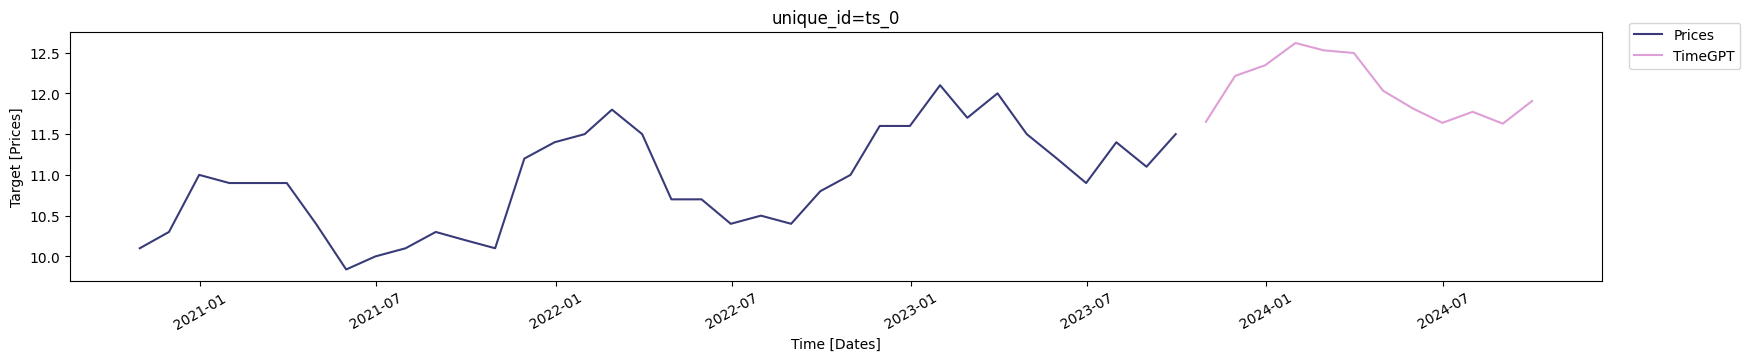

In [309]:
forecast_TimesGPT_df = nixtla_client.forecast(
    df=train_df,
    h=12,
    time_col='Dates',
    target_col="Prices"
)

# Plot predictions
# Pass the correct time_col and target_col arguments to nixtla_client.plot()
nixtla_client.plot(
    df=train_df,
    forecasts_df=forecast_TimesGPT_df,
    time_col='Dates',
    target_col='Prices'
)

## Evaluation Metrics:

In [310]:
# Evaluation Metrics
def evaluate_model(model_fit, y_true):
    y_pred = model_fit.fittedvalues
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    aic = model_fit.aic
    bic = model_fit.bic
    return mae, rmse, aic, bic

# Evaluation Metrics for GPT
def evaluate_gpt(y_true, y_pred):
    """
    Evaluates the model using common metrics like MAE and RMSE.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

mae_arima, rmse_arima, aic_arima, bic_arima = evaluate_model(model_arima_fit, NaturalGas['Prices'])
mae_sarima, rmse_sarima, aic_sarima, bic_sarima = evaluate_model(model_sarima_fit, NaturalGas['Prices'])
mae_ets, rmse_ets, aic_ets, bic_ets = evaluate_model(model_ets_fit, NaturalGas['Prices'])
mae_tgpt, rmse_tgpt = evaluate_gpt(merged_df['Prices'], merged_df['TimeGPT'])

print(f"ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, AIC: {aic_arima}, BIC: {bic_arima}")
print(f"SARIMA - MAE: {mae_sarima}, RMSE: {rmse_sarima}, AIC: {aic_sarima}, BIC: {bic_sarima}")
print(f"ETS - MAE: {mae_ets}, RMSE: {rmse_ets}, AIC: {aic_ets}, BIC: {bic_ets}")
print(f"TimeGPT - MAE: {mae_tgpt}, RMSE: {rmse_tgpt}")


ARIMA - MAE: 0.4601144450117369, RMSE: 1.4945361191754003, AIC: 42.15453179610496, BIC: 53.25541740636531
SARIMA - MAE: 0.5111148975412954, RMSE: 1.6584873212096836, AIC: 11.29104086535445, BIC: 23.733825357269758
ETS - MAE: 0.12121829063959222, RMSE: 0.1589264139803229, AIC: -144.57414294826884, BIC: -114.63492677374259
TimeGPT - MAE: 0.2956764166666666, RMSE: 0.3533965984205988


ETS has lowest MAE and RMSE, indicating the best performance among the four models.
TimeGPT Second-best performance, with relatively low MAE and RMSE.
This model is a strong contender, especially as it offers additional benefits like interpretability or ability to handle complex patterns and finetuning. Let us attempt to finetune TimeGPT and test performance

##Fine-Tuning TimeGPT with Mean Absolute Error:

In [311]:
finetune_mae_df = nixtla_client.forecast(
    df=train_df,
    model="timegpt-1",
    h=12,
    finetune_steps=120,  # Specify the number of steps for fine-tuning
    finetune_loss="mae",  # Specify the loss function for fine-tuning
    time_col="Dates",
    target_col="Prices",
)

In [312]:
finetune_mae_df["Dates"] = pd.to_datetime(finetune_mae_df["Dates"])
test_df["Dates"] = pd.to_datetime(test_df["Dates"])
merged_df = pd.merge(test_df, finetune_mae_df, "left", ["Dates"])

In [313]:
mae_tgpt, rmse_tgpt = evaluate_gpt(merged_df['Prices'], merged_df['TimeGPT'])

In [314]:
print(f"TimeGPT - MAE: {mae_tgpt}, RMSE: {rmse_tgpt}")

TimeGPT - MAE: 0.31455162499999983, RMSE: 0.4002490178903472


We observe finetuning did not improve the result. If we finetune TimeGPT with larger dataset it will give better result. However in the given situation ETS is the best performing model.

##Combining Forecasts and Plotting:

In [315]:
forecast_TimesGPT_df = nixtla_client.forecast(
    df=NaturalGas,
    model="timegpt-1",
    h=12,
    finetune_steps=120,  # Specify the number of steps for fine-tuning
    finetune_loss="mae",  # Specify the loss function for fine-tuning
    time_col="Dates",
    target_col="Prices",
)

In [316]:
# Combine with historical data
forecast_TimesGPT_df = pd.concat([NaturalGas, forecast_TimesGPT_df], ignore_index=True)

In [317]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Plotting
fig = px.line(NaturalGas, x='Dates', y='Prices', title='Natural Gas Prices Over Time')
fig.add_scatter(x=forecast_arima_df['Dates'], y=forecast_arima_df['Prices'], mode='lines', name='ARIMA Forecast')
fig.add_scatter(x=forecast_sarima_df['Dates'], y=forecast_sarima_df['Prices'], mode='lines', name='SARIMA Forecast')
fig.add_scatter(x=forecast_ets_df['Dates'], y=forecast_ets_df['Prices'], mode='lines', name='ETS Forecast')
fig.add_scatter(x=forecast_TimesGPT_df['Dates'], y=forecast_TimesGPT_df['TimeGPT'], mode='lines', name='TimeGPT Forecast')
fig.show()

mae_arima, rmse_arima, aic_arima, bic_arima = evaluate_model(model_arima_fit, NaturalGas['Prices'])
mae_sarima, rmse_sarima, aic_sarima, bic_sarima = evaluate_model(model_sarima_fit, NaturalGas['Prices'])
mae_ets, rmse_ets, aic_ets, bic_ets = evaluate_model(model_ets_fit, NaturalGas['Prices'])
mae_tgpt, rmse_tgpt = evaluate_gpt(merged_df['Prices'], merged_df['TimeGPT'])

print(f"ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, AIC: {aic_arima}, BIC: {bic_arima}")
print(f"SARIMA - MAE: {mae_sarima}, RMSE: {rmse_sarima}, AIC: {aic_sarima}, BIC: {bic_sarima}")
print(f"ETS - MAE: {mae_ets}, RMSE: {rmse_ets}, AIC: {aic_ets}, BIC: {bic_ets}")
print(f"TimeGPT - MAE: {mae_tgpt}, RMSE: {rmse_tgpt}")


ARIMA - MAE: 0.4601144450117369, RMSE: 1.4945361191754003, AIC: 42.15453179610496, BIC: 53.25541740636531
SARIMA - MAE: 0.5111148975412954, RMSE: 1.6584873212096836, AIC: 11.29104086535445, BIC: 23.733825357269758
ETS - MAE: 0.12121829063959222, RMSE: 0.1589264139803229, AIC: -144.57414294826884, BIC: -114.63492677374259
TimeGPT - MAE: 0.31455162499999983, RMSE: 0.4002490178903472


##Final Evaluation and Chat Function:

In [318]:
def estimate_price(date_str, historical_data, forecast_data):
    try:
        date = pd.to_datetime(date_str, format='%Y-%m-%d')
        if not pd.Timestamp(date).is_month_end:
            # Get the first day of the current month
            first_day_of_month = pd.Timestamp(date).replace(day=1)

            # Subtract one month to get the last day of the previous month
            date = first_day_of_month - pd.Timedelta(days=1)
        # else:
        #     return pd.Timestamp(date)
    except ValueError:
        return "Invalid date format. Please use YYYY-MM-DD."

    if date in historical_data['Dates'].values:
        # If the date is within the historical data range
        price = historical_data.loc[historical_data['Dates'] == date, 'Prices'].values[0]
        return f"The price on {date_str} was ${price:.2f}."

    elif date in forecast_data['Dates'].values:
        # If the date is within the forecast range
        price = forecast_data.loc[forecast_data['Dates'] == date, 'Prices'].values[0]
        return f"The estimated price on {date_str} is ${price:.2f}."

    elif date > historical_data['Dates'].max() and date <= forecast_data['Dates'].max():
        # If the date is within the forecast period but not in forecast_data directly
        return "The date is within the forecast period but not explicitly forecasted. Please check later dates."

    else:
        return "The date is outside the range of the available data."

def chat_function():
    print("Hello! I'm here to help with your natural gas price inquiries.")
    while True:
        user_input = input("Please enter a date (YYYY-MM-DD) to get a price estimate, or type 'exit' to end the chat: ")
        if user_input.lower() == 'exit':
            print("Goodbye! Have a great day!")
            break
        try:
            result = estimate_price(user_input, NaturalGas, forecast_ets_df)
            print(result)
        except Exception as e:
            print(f"An error occurred: {e}. Please try again.")
            print(f"Debugging Info - Forecast Dates: {forecast_ets_df['Dates'].min()} to {forecast_ets_df['Dates'].max()}")
            print(f"Historical Dates: {NaturalGas['Dates'].min()} to {NaturalGas['Dates'].max()}")

In [319]:
# Start the chat function
chat_function()

Hello! I'm here to help with your natural gas price inquiries.
Please enter a date (YYYY-MM-DD) to get a price estimate, or type 'exit' to end the chat: 2024-06-19
The price on 2024-06-19 was $11.40.
Please enter a date (YYYY-MM-DD) to get a price estimate, or type 'exit' to end the chat: exit
Goodbye! Have a great day!


##Prototype Model:

So, for example, if I can purchase a million MMBtu of natural gas in summer at 2/MMBtu, store this for four months, and ensure that I can sell the same quantity at $3/MMBtu without incurring any additional costs, the value of this contract would be (3-2) *1e6 = 1million. If there are costs involved, such as having to pay the storage facility owner a fixed fee of 100K a month, then the 'value' of the contract, from my perspective, would drop by the overall rental amount to 600K. Another cost could be the injection/withdrawal cost, like having to pay the storage facility owner 10K per 1 million MMBtu for injection/withdrawal, then the price will further go down by 10K to 590K. Additionally, if I am supposed to foot a bill of 50K each time for transporting the gas to and from the facility, the cost of this contract would fall by another 100K. Think of the valuation as a fair estimate at which both the trading desk and the client would be happy to enter into the contract.

Injection dates.
Withdrawal dates.
The prices at which the commodity can be purchased/sold on those dates.
The rate at which the gas can be injected/withdrawn.
The maximum volume that can be stored.
Storage costs.

In [320]:
def prototype_model(estimate_price, injectdate_str, withdrawdate_str, forecast_ets_df, rateInorOut, transportcost):

    inject_price_result = estimate_price(injectdate_str, NaturalGas,forecast_ets_df)

    withdraw_price_result = estimate_price(withdrawdate_str, NaturalGas,forecast_ets_df)


    if isinstance(inject_price_result, str):
        return f"Error in injection date: {inject_price_result}"
    if isinstance(withdraw_price_result, str):
        return f"Error in withdrawal date: {withdraw_price_result}"


    inject_price = float(inject_price_result.split('$')[1])
    withdraw_price = float(withdraw_price_result.split('$')[1])


    net_cost_or_gain = (withdraw_price - inject_price) * rateInorOut


    total_cost = net_cost_or_gain - transportcost

    return {
        'Injection Date': injectdate_str,
        'Injection Price': inject_price,
        'Withdrawal Date': withdrawdate_str,
        'Withdrawal Price': withdraw_price,
        'Rate': rateInorOut,
        'Transport Cost': transportcost,
        'Net Cost or Gain': net_cost_or_gain,
        'Total Profit/Loss': total_cost
    }

In [321]:
result = prototype_model(estimate_price, '2022-01-01', '2022-12-01',forecast_ets_df, 1000, 500)
print(result)

Error in injection date: The price on 2022-01-01 was $11.40.
